In [61]:
pip install tensorflow

Active code page: 1252
Note: you may need to restart the kernel to use updated packages.


In [62]:
import tensorflow as tf
print(tf.__version__)

2.20.0


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [64]:
df = pd.read_csv("../data/creditcard_scaled.csv")

In [65]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [66]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [67]:
# ---------------------------------------------------
# Isolation Forest
# ---------------------------------------------------
print("Isolation Forest")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=float(y_train.sum() / len(y_train)),
    random_state=42
)
iso_forest.fit(X_train)

Isolation Forest


,n_estimators,100
,max_samples,'auto'
,contamination,0.001729245759178389
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [68]:
y_pred_iso = iso_forest.predict(X_test)
# Convert from {1, -1} to {0, 1}
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

In [69]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))

Confusion Matrix:
[[56791    73]
 [   66    32]]


In [70]:
print("Classification Report:")
print(classification_report(y_test, y_pred_iso, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_iso))

Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9987    0.9988     56864
           1     0.3048    0.3265    0.3153        98

    accuracy                         0.9976     56962
   macro avg     0.6518    0.6626    0.6570     56962
weighted avg     0.9976    0.9976    0.9976     56962

ROC-AUC: 0.662623423736405


In [71]:
# ---------------------------------------------------
# AutoEncoder
# ---------------------------------------------------
print("\n=== AutoEncoder ===")
# Build AE
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


=== AutoEncoder ===


c:\Users\elias\OneDrive\Documents\CreditCardDetectionFraud\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
# Train AE only on normal transactions
X_train_normal = X_train[y_train == 0]
autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
) 

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6746 - val_loss: 0.5218
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4340 - val_loss: 0.3902
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3778 - val_loss: 0.3594
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3602 - val_loss: 0.3489
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3520 - val_loss: 0.3439
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3470 - val_loss: 0.3372
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3407 - val_loss: 0.3318
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3349 - val_loss: 0.3251
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3315 - val_loss: 0.3229
Epoch 10/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3296 - val_loss: 0.3228


In [73]:
# Reconstruction error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step


In [74]:
# Choose threshold (can adjust)
threshold = np.percentile(mse, 95)  # top 5% as anomalies
y_pred_ae = (mse > threshold).astype(int)

In [75]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ae))
print("Classification Report:")
print(classification_report(y_test, y_pred_ae, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_ae))

Confusion Matrix:
[[54104  2760]
 [    9    89]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9515    0.9750     56864
           1     0.0312    0.9082    0.0604        98

    accuracy                         0.9514     56962
   macro avg     0.5155    0.9298    0.5177     56962
weighted avg     0.9982    0.9514    0.9735     56962

ROC-AUC: 0.9298132027149634


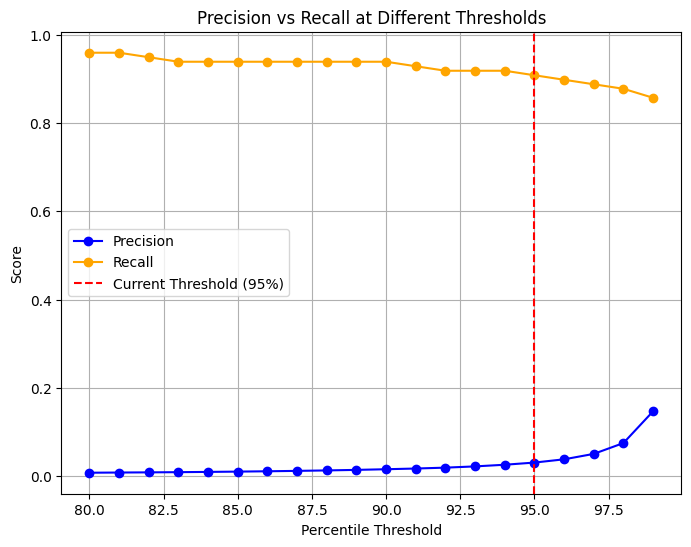

In [76]:
# Threshold Sweep Plot
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Store results
percentiles = range(80, 100)  # check thresholds from 80th to 99th percentile
precisions = []
recalls = []

for p in percentiles:
    threshold = np.percentile(mse, p)
    y_pred = (mse > threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(percentiles, precisions, marker='o', label='Precision', color='blue')
plt.plot(percentiles, recalls, marker='o', label='Recall', color='orange')
plt.axvline(x=95, color='red', linestyle='--', label='Current Threshold (95%)')
plt.xlabel("Percentile Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall at Different Thresholds")
plt.legend()
plt.grid(True)
plt.show()


COMPARISON OF BOTH MODELS

In [77]:
print("=== AutoEncoder Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_ae))
print(classification_report(y_test, y_pred_ae, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_ae))
print("\n")

print("=== Isolation Forest Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_iso))
print(classification_report(y_test, y_pred_iso, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_iso))
print("\n")

=== AutoEncoder Confusion Matrix ===
[[54104  2760]
 [    9    89]]
              precision    recall  f1-score   support

           0     0.9998    0.9515    0.9750     56864
           1     0.0312    0.9082    0.0604        98

    accuracy                         0.9514     56962
   macro avg     0.5155    0.9298    0.5177     56962
weighted avg     0.9982    0.9514    0.9735     56962

ROC-AUC: 0.9298132027149634


=== Isolation Forest Confusion Matrix ===
[[56791    73]
 [   66    32]]
              precision    recall  f1-score   support

           0     0.9988    0.9987    0.9988     56864
           1     0.3048    0.3265    0.3153        98

    accuracy                         0.9976     56962
   macro avg     0.6518    0.6626    0.6570     56962
weighted avg     0.9976    0.9976    0.9976     56962

ROC-AUC: 0.662623423736405




In [78]:
# -------------------------
# Agreement (both must say fraud)
# -------------------------
y_pred_agreement = ((y_pred_ae == 1) & (y_pred_iso == 1)).astype(int)
print("=== Agreement Rule (Intersection) ===")
print(confusion_matrix(y_test, y_pred_agreement))
print(classification_report(y_test, y_pred_agreement, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_agreement))
print("\n")

=== Agreement Rule (Intersection) ===
[[56791    73]
 [   66    32]]
              precision    recall  f1-score   support

           0     0.9988    0.9987    0.9988     56864
           1     0.3048    0.3265    0.3153        98

    accuracy                         0.9976     56962
   macro avg     0.6518    0.6626    0.6570     56962
weighted avg     0.9976    0.9976    0.9976     56962

ROC-AUC: 0.662623423736405




In [79]:
# -------------------------
# Union (either says fraud)
# -------------------------
y_pred_union = ((y_pred_ae == 1) | (y_pred_iso == 1)).astype(int)
print("=== Union Rule (Either) ===")
print(confusion_matrix(y_test, y_pred_union))
print(classification_report(y_test, y_pred_union, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_union))
print("\n")

=== Union Rule (Either) ===
[[54104  2760]
 [    9    89]]
              precision    recall  f1-score   support

           0     0.9998    0.9515    0.9750     56864
           1     0.0312    0.9082    0.0604        98

    accuracy                         0.9514     56962
   macro avg     0.5155    0.9298    0.5177     56962
weighted avg     0.9982    0.9514    0.9735     56962

ROC-AUC: 0.9298132027149634




In [ ]:
# -------------------------
# Score Averaging
# For AutoEncoder, score = mse
# For Isolation Forest, score = -decision_function (higher = more anomalous)
# -------------------------
iso_scores = -iso_forest.decision_function(X_test)  # higher = more anomaly-like
ae_scores = mse

# Normalize scores between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ae_scores_scaled = scaler.fit_transform(np.array(ae_scores).reshape(-1, 1)).ravel()
iso_scores_scaled = scaler.fit_transform(np.array(iso_scores).reshape(-1, 1)).ravel()

# Average score
combined_scores = 0.5 * ae_scores_scaled + 0.5 * iso_scores_scaled

# Pick threshold — here we use top 5% as anomalies
threshold_combined = np.percentile(combined_scores, 95)
# Find smallest amount among actual fraud cases
min_fraud_amount = X_test[y_test == 1]['scaled_Amount'].min()
small_amount_threshold = min_fraud_amount - 1e-6  # guarantees we don't cut real fraud

# Final predictions with amount filter
y_pred_avg = (
    (combined_scores > threshold_combined) &
    (X_test['scaled_Amount'] > small_amount_threshold)
).astype(int)

print("=== Score Averaging (50/50) ===")
print(confusion_matrix(y_test, y_pred_avg))
print(classification_report(y_test, y_pred_avg, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_avg))

=== Score Averaging (50/50) ===
[[54100  2764]
 [   13    85]]
              precision    recall  f1-score   support

           0     0.9998    0.9514    0.9750     56864
           1     0.0298    0.8673    0.0577        98

    accuracy                         0.9512     56962
   macro avg     0.5148    0.9094    0.5163     56962
weighted avg     0.9981    0.9512    0.9734     56962

ROC-AUC: 0.9093698678120657


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train XGBoost model
xgb = XGBClassifier(
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # balance classes
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predict with default threshold = 0.5
proba_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (proba_xgb > 0.5).astype(int)

print("=== XGBoost (Default Threshold 0.5) ===")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, proba_xgb))

# Tune threshold for Recall >= 0.85
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba_xgb)
recall_min = 0.85
candidates = [(t, p, r, (2*p*r)/(p+r)) for t, p, r in zip(thresholds, precision[:-1], recall[:-1]) if r >= recall_min]
best_thresh = max(candidates, key=lambda x: x[2])[0] if candidates else 0.5

# Predict with tuned threshold
y_pred_xgb_tuned = (proba_xgb > best_thresh).astype(int)

print(f"\n=== XGBoost (Tuned Threshold={best_thresh:.3f} for Recall ≥ {recall_min}) ===")
print(confusion_matrix(y_test, y_pred_xgb_tuned))
print(classification_report(y_test, y_pred_xgb_tuned, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, proba_xgb))

c:\Users\elias\OneDrive\Documents\CreditCardDetectionFraud\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:13:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost (Default Threshold 0.5) ===
[[56853    11]
 [   15    83]]
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8830    0.8469    0.8646        98

    accuracy                         0.9995     56962
   macro avg     0.9414    0.9234    0.9322     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC: 0.9652206338359767

=== XGBoost (Tuned Threshold=0.000 for Recall ≥ 0.85) ===
[[    1 56863]
 [    0    98]]
              precision    recall  f1-score   support

           0     1.0000    0.0000    0.0000     56864
           1     0.0017    1.0000    0.0034        98

    accuracy                         0.0017     56962
   macro avg     0.5009    0.5000    0.0017     56962
weighted avg     0.9983    0.0017    0.0000     56962

ROC-AUC: 0.9652206338359767
